# GIS Project - 서울시 건물물리정보 기반 GEO-SOM 클러스터링 및 K-Means 재군집화

본 프로젝트는 서울시 용도별 건물 데이터를 활용하여, 건축물의 물리적 특성(용적률, 건폐율, 높이, 총 층수, 건물 나이)을 기반으로  
도시 공간을 **데이터 중심의 새로운 관점**에서 군집화하는 것을 목표로 한다.  

먼저 GEO-SOM(Self-Organizing Map) 알고리즘을 사용하여 각 건물을 고차원 공간에서 유사 특성을 지닌 클러스터로 분류하였다.  
이후, 클러스터가 할당된 개별 건물 포인트를 바탕으로 보로노이(Voronoi) 폴리곤을 생성하여,  
공간적 군집 구조를 시각화하고 직관적으로 이해할 수 있는 형태로 표현하였다.  

그러나 GEO-SOM 결과는 클러스터 수가 많고 분산되어 해석이 어려운 한계가 있어,  
2차적으로 K-Means 알고리즘을 적용하였다.  
건물 위치 좌표(x, y)와 GEO-SOM 클러스터 중심 좌표(x′, y′)를 결합한 4차원 벡터를 기반으로 군집을 재구성하였고,  
Gap Statistic을 활용하여 최적의 군집 수를 결정함으로써 공간적으로 응집력 있고 해석 가능한 결과를 도출하였다.  

이 분석은 전통적인 인구통계 기반 접근과 달리, **건축물 물리 정보 중심의 도시 구조 이해**를 가능케 하며,  
향후 도시계획, 재개발, 환경 개선 등 다양한 분야에 실용적인 인사이트를 제공할 수 있다.


1. 분석 배경 및 목표

기존의 서울시 공간 군집 분석은 대부분 인구, 소득, 연령 등 인구사회학적 데이터를 기반으로 이루어졌으며, 그 결과로 강남3구(강남, 서초, 송파), 강북지역, 영등포 등과 같이 이미 널리 알려진 공간 클러스터들이 반복적으로 등장하는 경향이 있습니다.하지만 우리는 **서울을 물리적인 건축 환경의 관점에서 새롭게 바라볼 수는 없을까?**라는 문제의식에서 출발하였습니다.따라서 이번 프로젝트의 목적은 서울시의 건물정보를 기반으로 공간 군집을 시도함으로써, 물리적 도시구조의 패턴을 발견하고 이를 해석하는 것입니다.

이는 “Let data speak for themselves” (Gould 1981) 라는 원칙 아래, 선입견 없는 데이터 중심의 도시 정책 접근을 모색하려는 시도의 일환입니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


**Team Member & Roles**

*   19학번 정형민: 프로젝트 구조 기획, GEO-SOM 알고리즘 구현
*   22학번 류효민: 데이터 수집 및 전처리, 데이터 해석 및 도시공간 구조 해석
*   23학번 유아연: GEO-SOM 알고리즘 논문 분석 및 알고리즘 구현



**Data Aquisition**   
국토교통부 V-world에서 <용도별건물정보> shp파일 취득   
[V-World 링크](https://www.vworld.kr/)      

data가 각 구 별로 존재 - 서울시 25개 구 shp파일 다운로드 후, append 진행   
용도별 건물정보가 폴리곤임으로 centroid로 변환 후, append해주는게 오류없이 돌아갈 것 같음




**브이 월드 API**
용도별 건물정보가 브이월드 API에 존재하여, API로도 데이터 취득이 가능하다.   
하지만, 한번의 응답에 1000개의 리턴을 주기때문에,   
빠른 분석을 위하여, zip파일을 다운로드하여 클라우드에 업로드하여 진행하였다.


```
# Import necessary packages
import requests
import geopandas as gpd
import pandas as pd
from urllib.parse import urlencode

YOUR_API_KEY = 'enter your key here'

# The destination URL for the WFS API
url_wfs = 'https://api.vworld.kr/req/wfs?'

# The parameters for the WFS API request
build_params = {
    'SERVICE':'WFS',
    'version': '2.0.0',
    'REQUEST':'GetFeature',
    'key': YOUR_API_KEY,
    'output': 'application/json',
    'typename': '', # 건물 레이어
}

# gpd.read_file can only read a URL with the parameters in the query string. Parameters should be encoded.
build_query = urlencode(build_params)
print("String Encoded Parameters:")
print(build_query)

url_build = url_wfs+build_query

print(url_build)


build_gdf = gpd.read_file(url_build)
build_gdf = build_gdf.to_crs('epsg:5179')

build_gdf

```



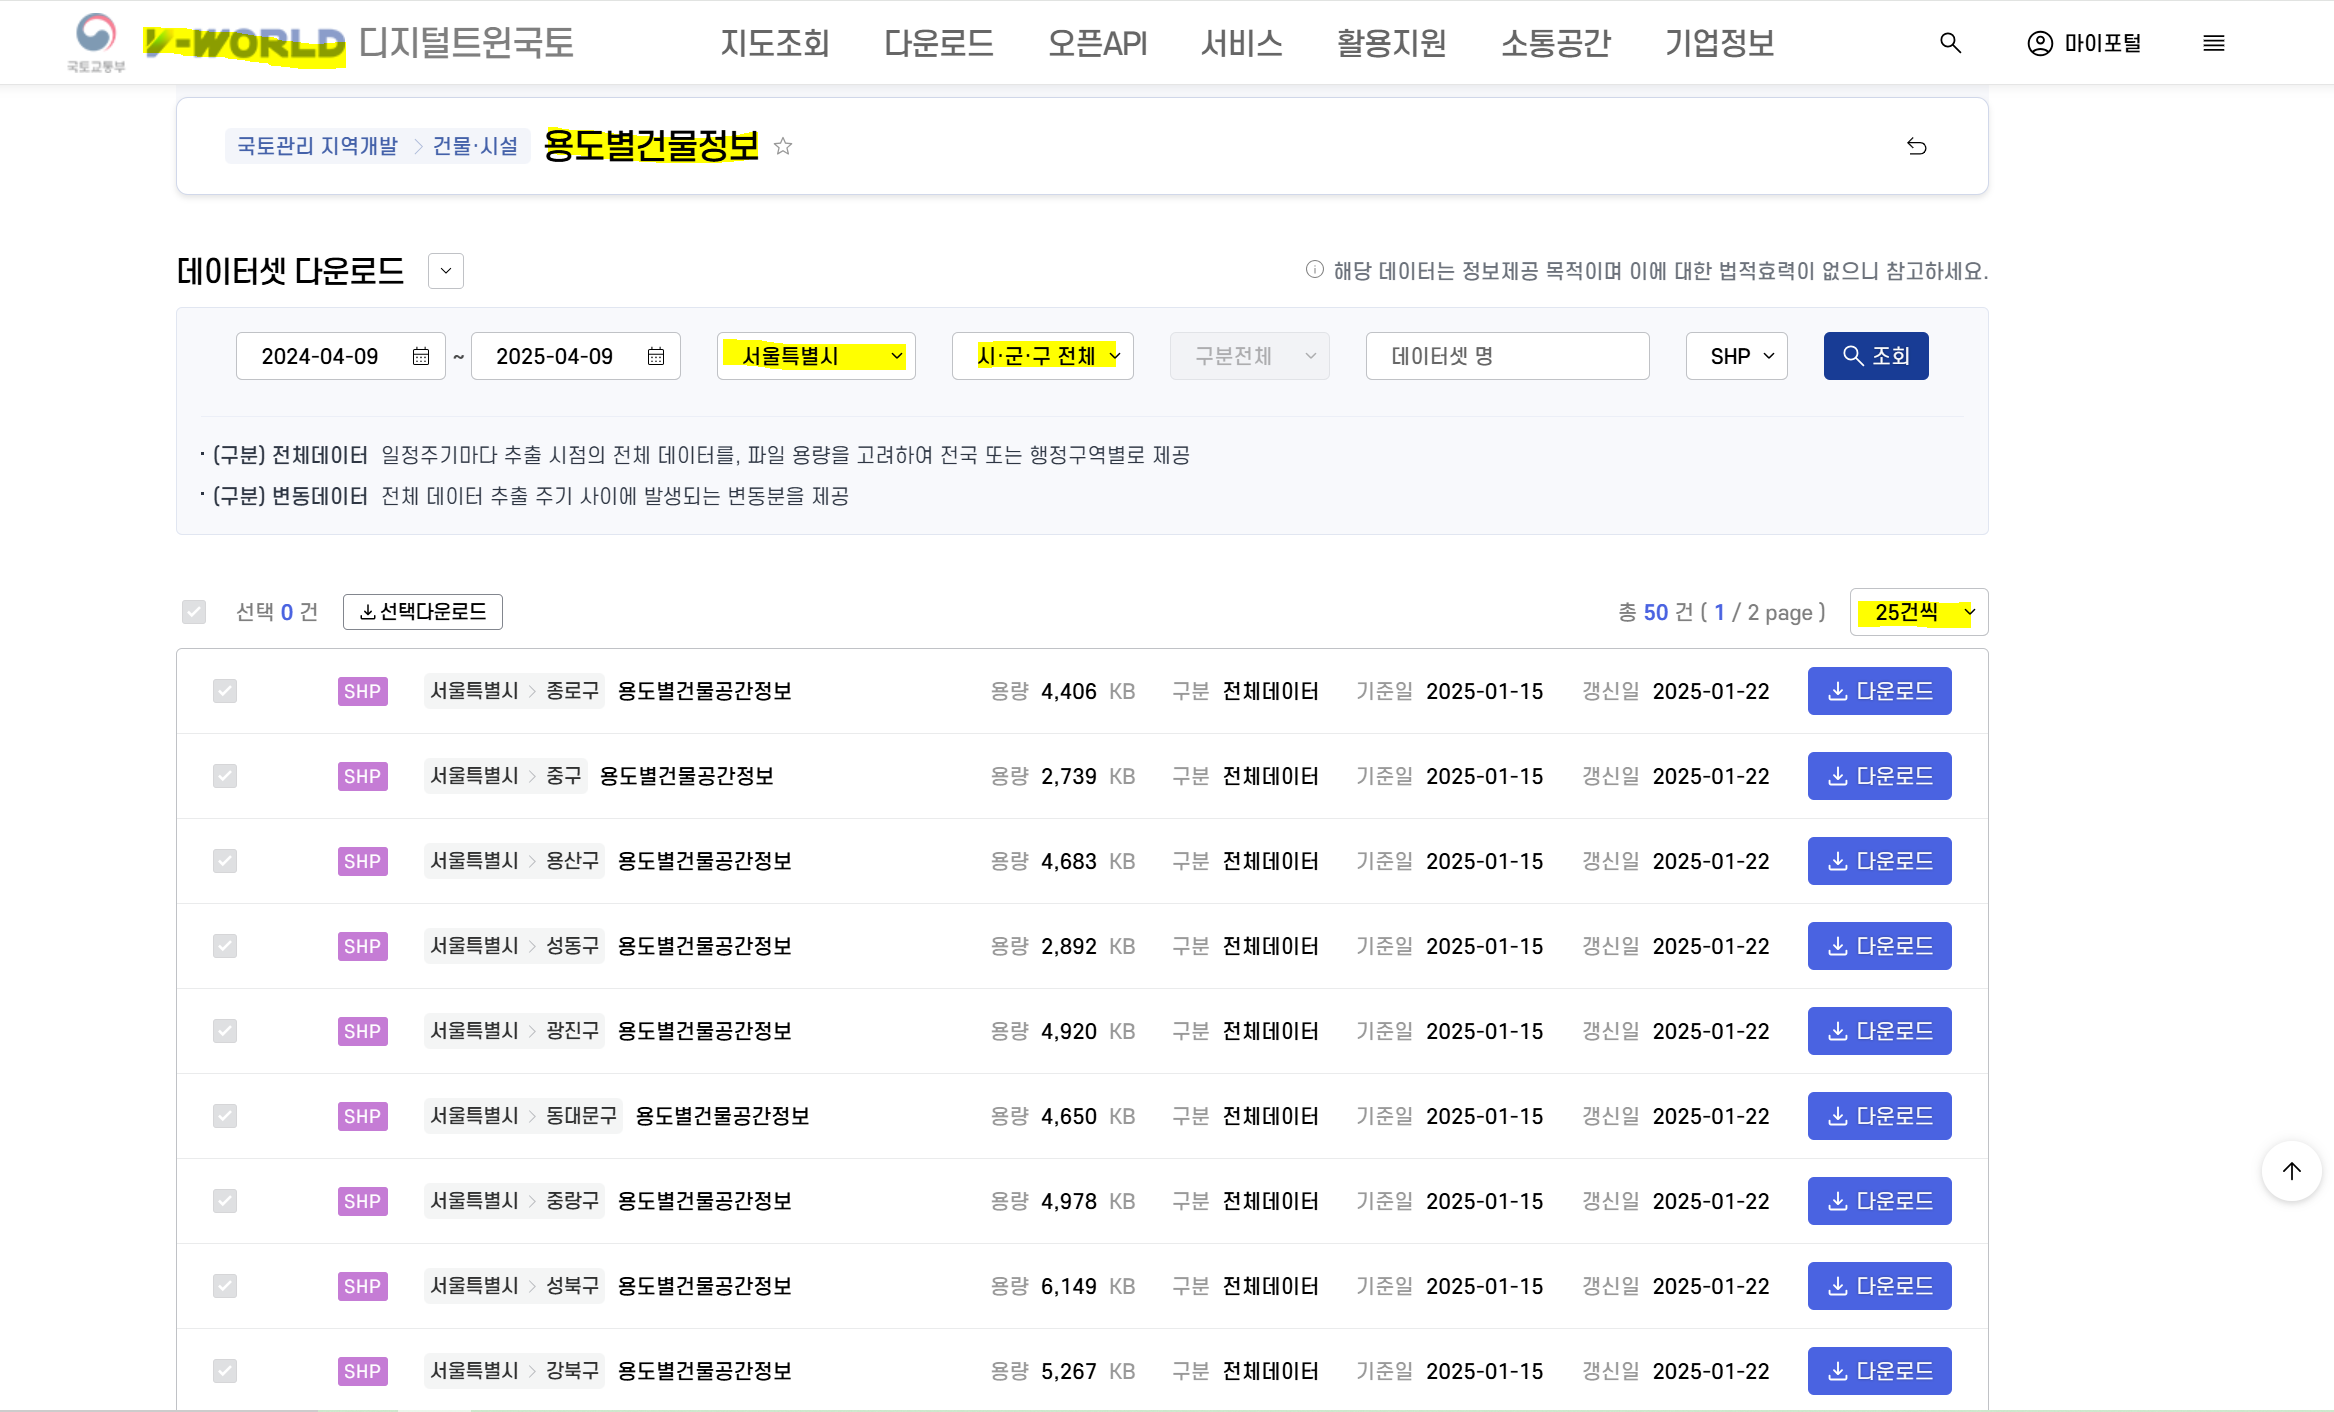

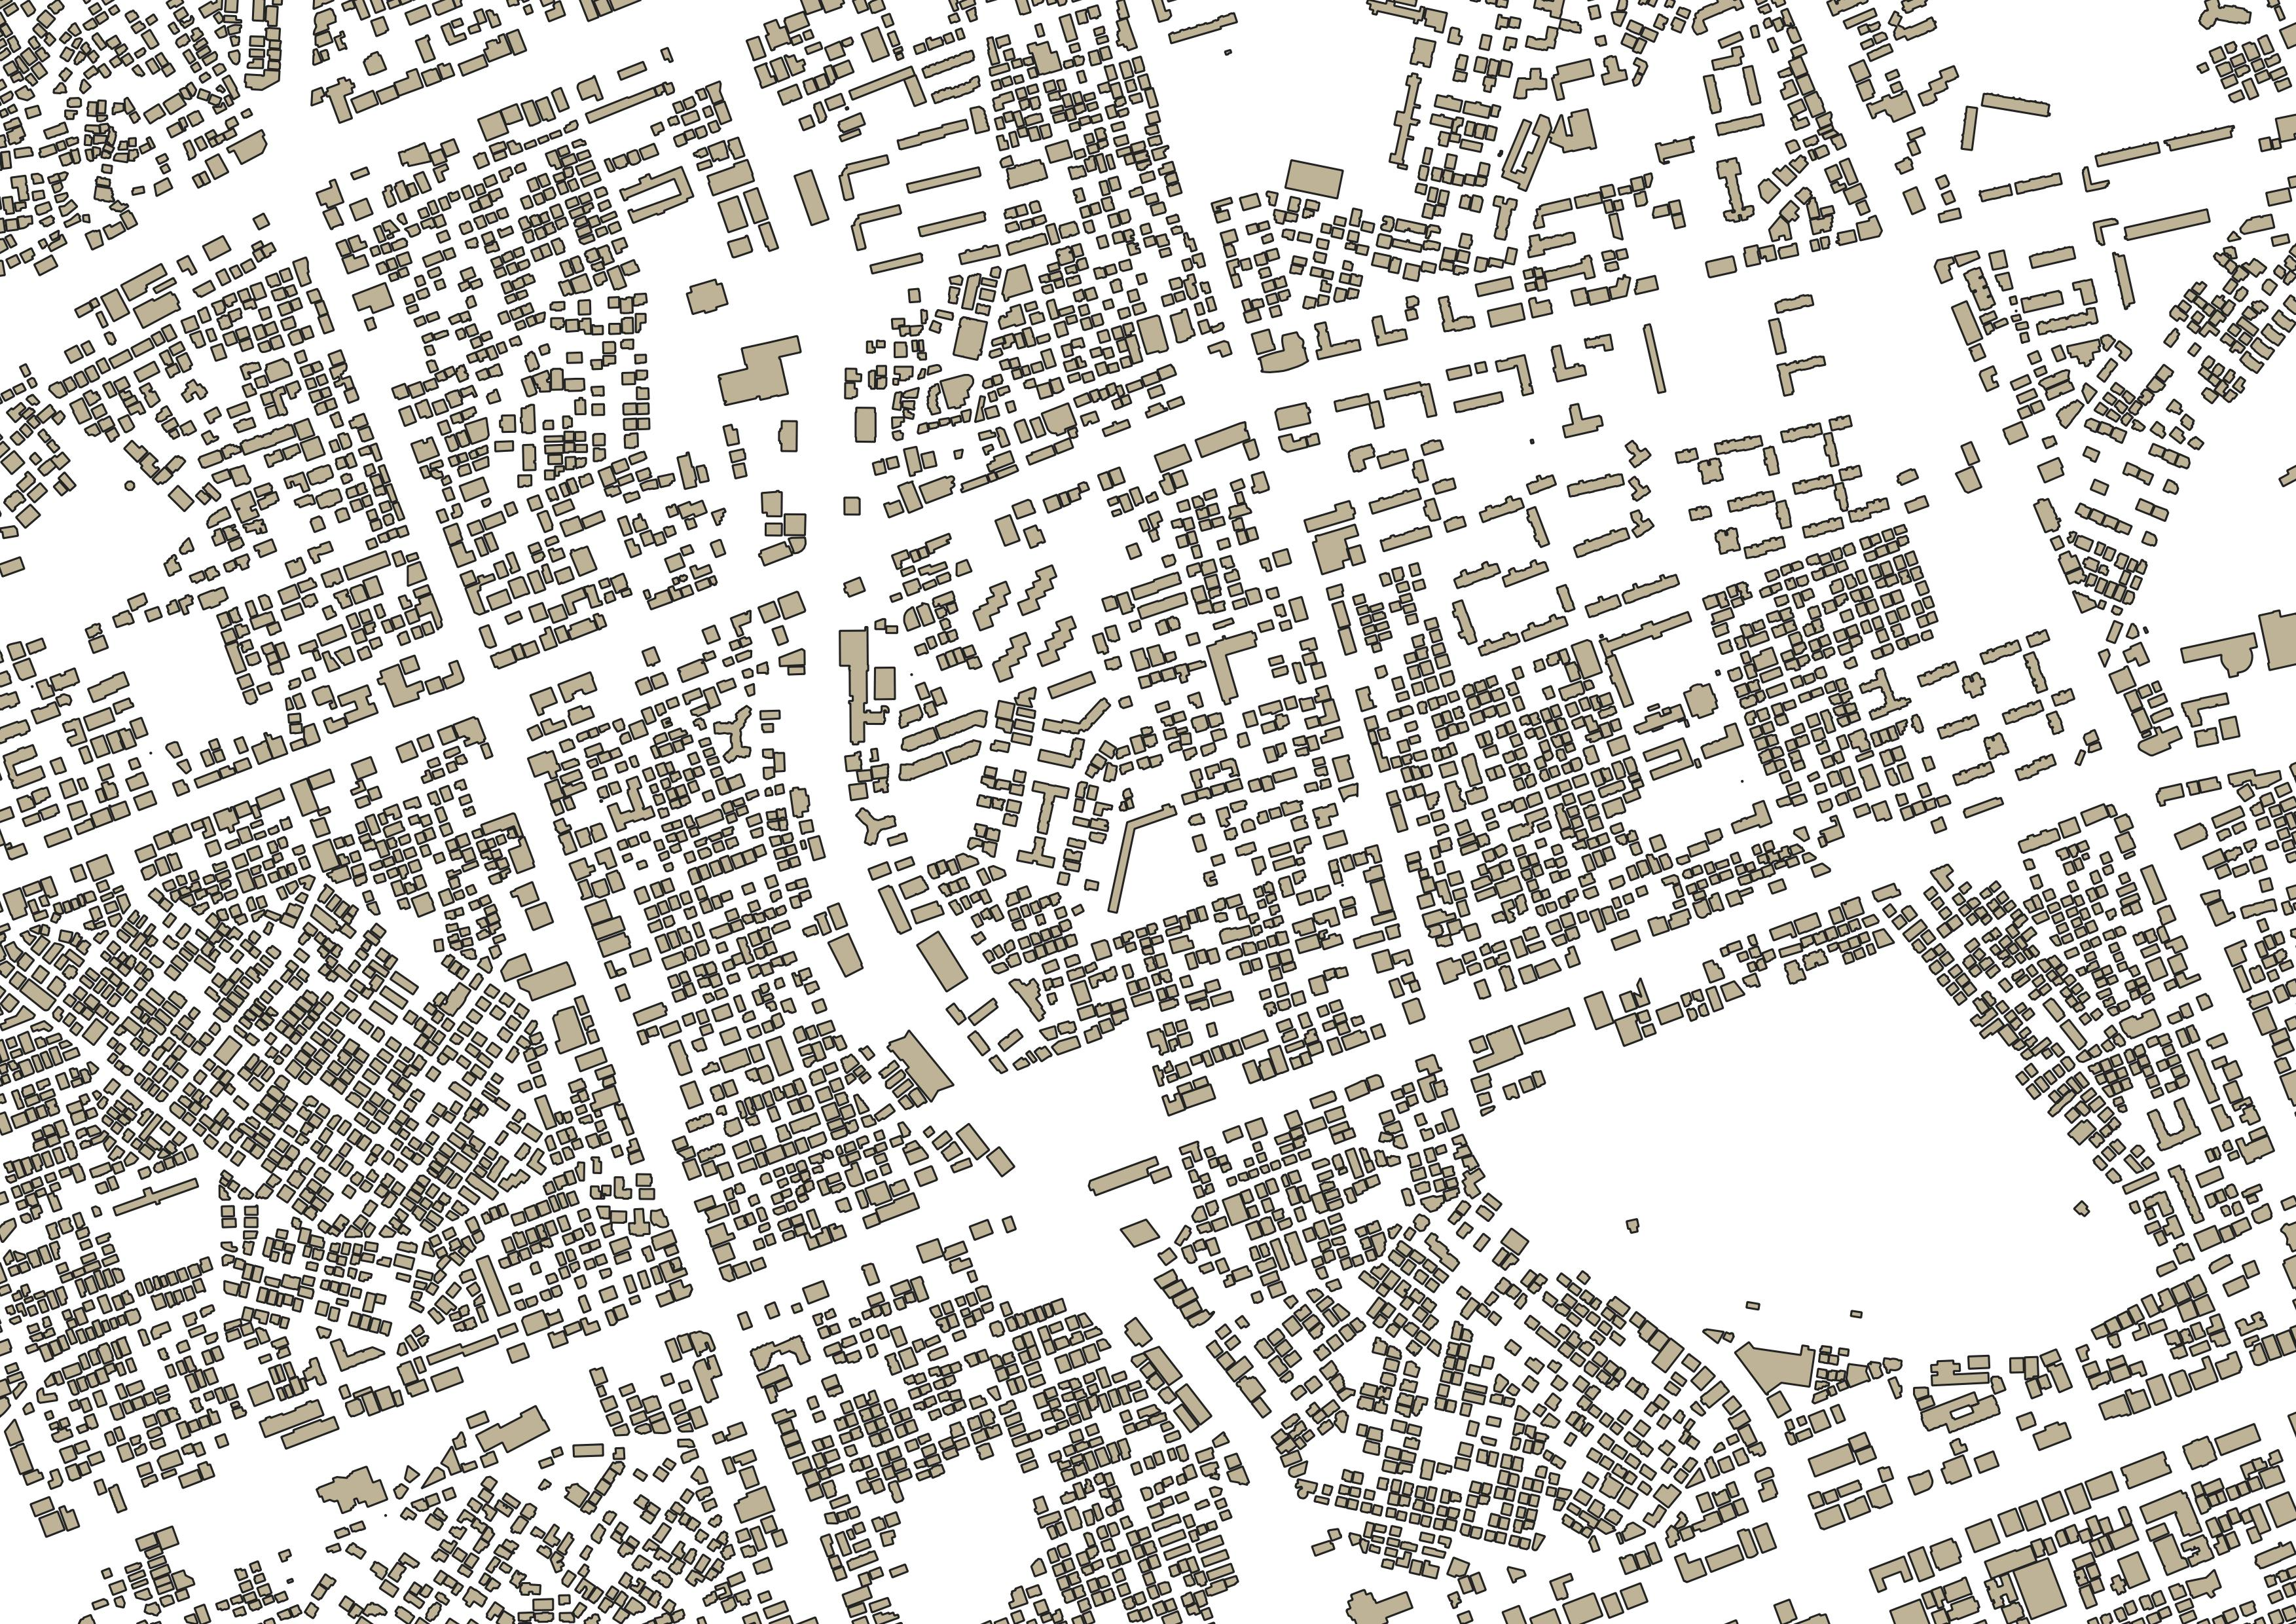

**Data Column Definition**   
data파일의 <국가중점데이터_컬럼정의서(25.04.04)_배포용>을 확인하면 각 칼럼의 의미를 확인할 수 있음

| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 1  | A0  | 도형ID        | 9     | 필수 |
| ------- | --------- | ------- | --- | -- | --- | ----------- | ----- | -- |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 2  | A1  | GIS건물통합식별번호 | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 3  | A2  | 고유번호        | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 4  | A3  | 법정동코드       | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 5  | A4  | 법정동명        | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 6  | A5  | 특수지구분코드     | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 7  | A6  | 특수지구분명      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 8  | A7  | 지번          | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 9  | A8  | 건물식별번호      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 10 | A9  | 집합건물구분코드    | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 11 | A10 | 집합건물구분      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 12 | A11 | 대장종류코드      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 13 | A12 | 대장종류        | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 14 | A13 | 건물명         | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 15 | A14 | 건물동명        | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 16 | A15 | 건물주부구분코드    | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 17 | A16 | 건물주부구분명     | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 18 | A17 | 건물대지면적(㎡)   | 31,15 |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 19 | A18 | 건물건축면적(㎡)   | 31,15 |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 20 | A19 | 건물연면적(㎡)    | 31,15 |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 21 | A20 | 용적율(%)      | 9     |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 22 | A21 | 건폐율(%)      | 9     |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 23 | A22 | 건축물구조코드     | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 24 | A23 | 건축물구조명      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 25 | A24 | 주요용도코드      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 26 | A25 | 주요용도명       | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 27 | A26 | 세부용도코드      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 28 | A27 | 세부용도명       | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 29 | A28 | 건물용도분류코드    | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 30 | A29 | 건물용도분류명     | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 31 | A30 | 건물높이(m)     | 31,15 |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 32 | A31 | 지상층수        | 9     |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 33 | A32 | 지하층수        | 9     |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 34 | A33 | 허가일자        | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 35 | A34 | 사용승인일자      | 254   |    |
| 용도별건물정보 | 용도별건물공간정보 | AL_D198 | SHP | 36 | A35 | 데이터기준일자     | 254   |    |

2. 데이터 및 변수

분석에는 **서울시의 용도별 건물정보 데이터 (shapefile)**를 활용하였으며, 이 데이터에는 각 건물의 위치와 속성이 포함되어 있습니다.

사용된 주요 변수 (5개 벡터):

용적률 (Floor Area Ratio)

건폐율 (Building Coverage Ratio)

건물 높이 (in meters)

총 층수 (지상 + 지하)

건물 나이 (2025년 기준 승인일자로부터 경과한 연수)

Select Which Features (Vectors) Would Influence Our Research

Geo-SOM 알고리즘은 각 feature가 output node에 완전히 연결되는 구조를 갖는다.따라서 feature가 하나 추가될 때마다, 하나의 epoch 내에서 수행되는 연산이 PxQ만큼 증가하게 된다.

이번 연구는 CBD, GBD, YBD와 같이 기존 인구사회학적 특성이 반영된 클러스터링과는 달리,데이터 기반의 새로운 공간 분류를 지향한다.이에 따라 건물의 물리적·객관적 특성만을 고려하여 feature를 선택하는 것이 핵심이다.이는 분석의 순수성을 확보하고, 의미 있는 클러스터링 결과를 도출하는 데 기여할 것이다.

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

In [ ]:
# 코드의 시각적 편의를 위해 함수를 utils.py에 넣어놓고 사용
import sys

util = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/'
sys.path.append(util)
from utils import *

ModuleNotFoundError: No module named 'utils'

In [ ]:

path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/data'
list_dir = os.listdir(path)
shp_list = []
for list_name in list_dir:
    print(f"{path}/{list_name}/{list_name}.shp")
    shp_list.append(f"{path}/{list_name}/{list_name}.shp")

/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11215_20250115/AL_D198_11215_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11110_20250115/AL_D198_11110_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11140_20250115/AL_D198_11140_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11170_20250115/AL_D198_11170_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11200_20250115/AL_D198_11200_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11230_20250115/AL_D198_11230_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11260_20250115/AL_D198_11260_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11290_20250115/AL_D198_11290_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11305_20250115/AL_D198_11305_20250115.shp
/content/drive/MyDrive/GIS_Project_GEO_SOM조/data/AL_D198_11320_20250115/AL_D198_11320_20250115.shp


In [ ]:
# 서울 shape파일 불러오기
path2 = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/data2/seoulBoundary'
seoul_gdf = gpd.read_file(os.path.join(path2,'seoul_boundary.shp'))

In [ ]:
seoul_gdf

id ctprvn_cd ctp_eng_nm ctp_kor_nm cat_cde cat_nam  \
0  lt_c_adsido_info.936        11      Seoul      서울특별시  CAT001    시도경계   

                                            geometry  
0  POLYGON ((940286.568 1945875.197, 940267.507 1...

**법정동 코드검색**   
링크: https://www.code.go.kr/stdcode/regCodeL.do   


In [ ]:
#서울 법정동코드 Ditionary
seoul_code_dict = {
    '1121500000' : '광진구',
    '1111000000' : '종로구',
    '1114000000' : '중구',
    '1117000000' : '용산구',
    '1120000000' : '성동구',
    '1123000000' : '동대문구',
    '1126000000' : '중랑구',
    '1129000000' : '성북구',
    '1130500000' : '강북구',
    '1132000000' : '도봉구',
    '1135000000' : '노원구',
    '1138000000' : '은평구',
    '1141000000' : '서대문구',
    '1144000000' : '마포구',
    '1147000000' : '양천구',
    '1150000000' : '강서구',
    '1153000000' : '구로구',
    '1154500000' : '금천구',
    '1156000000' : '영등포구',
    '1159000000' : '동작구',
    '1162000000' : '관악구',
    '1165000000' : '서초구',
    '1168000000' : '강남구',
    '1171000000' : '송파구',
    '1174000000' : '강동구'
}

In [ ]:
guName_gpd = []
for name in seoul_code_dict.values():
    guName_gpd.append(f'{name}_gdf')




In [ ]:
guName_gpd

['광진구_gdf',
 '종로구_gdf',
 '중구_gdf',
 '용산구_gdf',
 '성동구_gdf',
 '동대문구_gdf',
 '중랑구_gdf',
 '성북구_gdf',
 '강북구_gdf',
 '도봉구_gdf',
 '노원구_gdf',
 '은평구_gdf',
 '서대문구_gdf',
 '마포구_gdf',
 '양천구_gdf',
 '강서구_gdf',
 '구로구_gdf',
 '금천구_gdf',
 '영등포구_gdf',
 '동작구_gdf',
 '관악구_gdf',
 '서초구_gdf',
 '강남구_gdf',
 '송파구_gdf',
 '강동구_gdf']

In [ ]:
for name in guName_gpd:
  print(f'{name},')

광진구_gdf,
종로구_gdf,
중구_gdf,
용산구_gdf,
성동구_gdf,
동대문구_gdf,
중랑구_gdf,
성북구_gdf,
강북구_gdf,
도봉구_gdf,
노원구_gdf,
은평구_gdf,
서대문구_gdf,
마포구_gdf,
양천구_gdf,
강서구_gdf,
구로구_gdf,
금천구_gdf,
영등포구_gdf,
동작구_gdf,
관악구_gdf,
서초구_gdf,
강남구_gdf,
송파구_gdf,
강동구_gdf,


In [ ]:
# 서울 구별 shp파일 XX구_gdf으로 읽어오기
for idx in range(len(shp_list)):
    globals()[guName_gpd[idx]] = gpd.read_file(shp_list[idx], encoding='euc-kr')

#강북구 파일 수정

<Axes: >

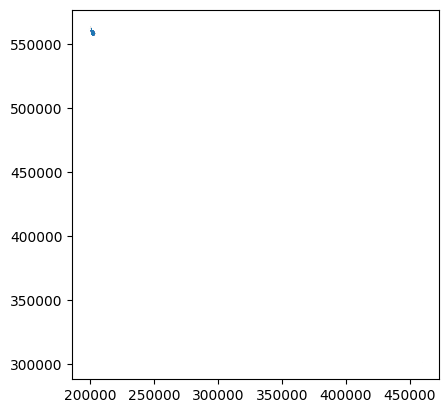

In [ ]:
# 강북구 shp파일에 outlier가 존재하여 plot이 이상함
강북구_gdf.plot()

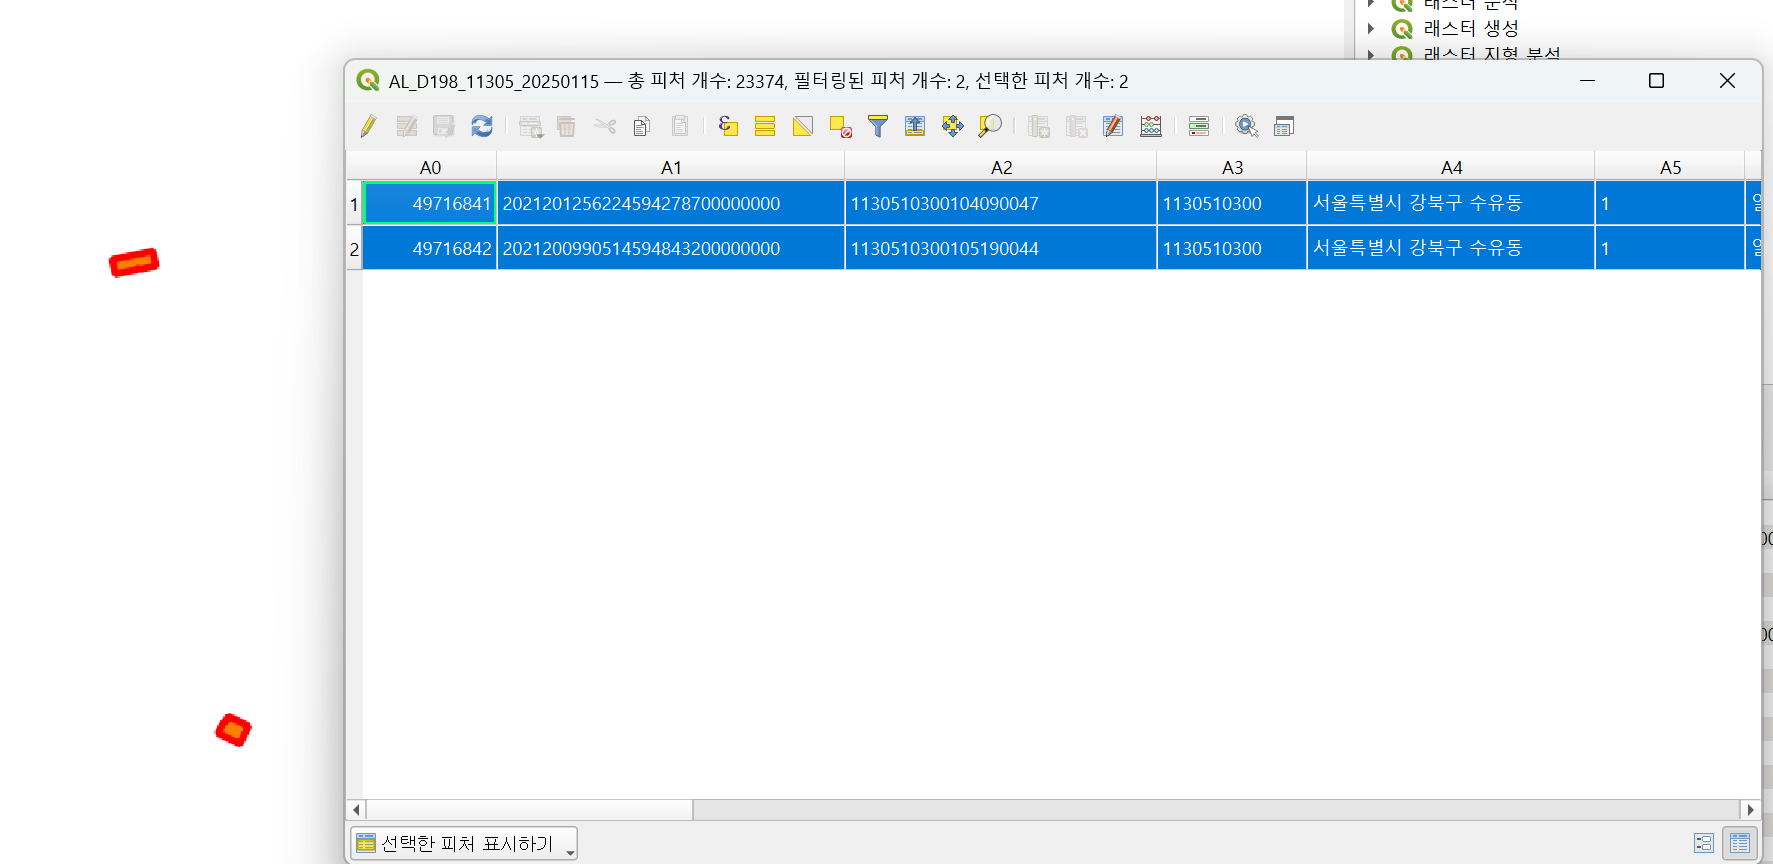

<Axes: >

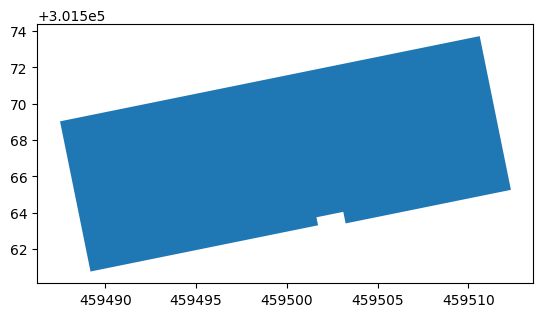

In [ ]:
# 강북구 outlier 번호(A2 기준): 1130510300104090047 , 1130510300105190044
condition01 = (강북구_gdf['A2'] == '1130510300104090047')
condition02 = (강북구_gdf['A2'] == '1130510300105190044')
강북구_gdf[condition01].plot()



<Axes: >

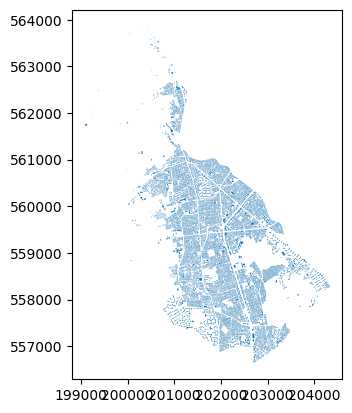

In [ ]:
# Outlier 2개를 제거하였을 경우 강북구 plot
강북구_gdf.loc[~(condition01 | condition02),:].plot()

In [ ]:
# 이상치 데이터 제거 후 저장
강북구_gdf = 강북구_gdf.loc[~(condition01 | condition02),:]

# shp파일 합치기

In [ ]:
# GeoDataFrame 합치기
gdf_combined = pd.concat([광진구_gdf,
종로구_gdf,
중구_gdf,
용산구_gdf,
성동구_gdf,
동대문구_gdf,
중랑구_gdf,
성북구_gdf,
강북구_gdf,
도봉구_gdf,
노원구_gdf,
은평구_gdf,
서대문구_gdf,
마포구_gdf,
양천구_gdf,
강서구_gdf,
구로구_gdf,
금천구_gdf,
영등포구_gdf,
동작구_gdf,
관악구_gdf,
서초구_gdf,
강남구_gdf,
송파구_gdf,
강동구_gdf], ignore_index=True)

# GeoDataFrame으로 캐스팅 (geometry 정보 유지)
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry')

<Axes: >

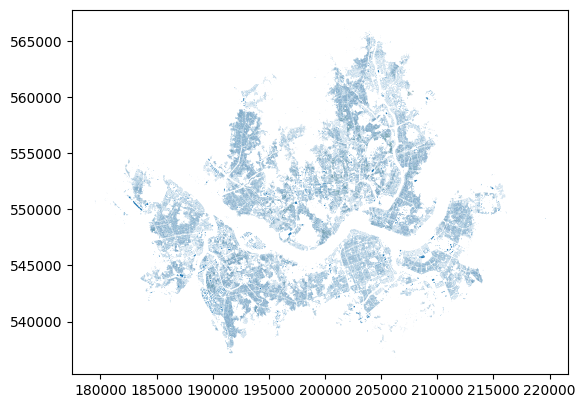

In [ ]:
gdf_combined.plot()

In [ ]:
# centroid 좌표로 geometry를 변환한 GeoDataFrame 생성
gdf_combined_centroid = gdf_combined.copy()
gdf_combined_centroid['geometry'] = gdf_combined_centroid.geometry.centroid
#gdf_combined_centroid.plot()

In [ ]:
gdf_combined_centroid = gdf_combined_centroid.to_crs('epsg:5179')

In [ ]:
gdf_combined_centroid.crs

<Projected CRS: EPSG:5179>
Name: KGD2002 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# 서울 데이터 전처리 및 변수 선택   

geo데이터프레임에서 그냥 dropna를 하면 2만개 밖에 안 남게된다.   
1. 필요한 변수를 선택   
2. 필요한 형변환   
3. Min-Max 표준화

In [ ]:
gdf_combined_centroid.loc[:,['A20','A21','A30','A31','A32','A34']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449719 entries, 0 to 449718
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   A20     441301 non-null  float64
 1   A21     441680 non-null  float64
 2   A30     448617 non-null  float64
 3   A31     449560 non-null  float64
 4   A32     440310 non-null  float64
 5   A34     436954 non-null  object 
dtypes: float64(5), object(1)
memory usage: 20.6+ MB


In [ ]:
selected_gdf = gdf_combined_centroid.loc[:,['A20','A21','A30','A31','A32','A34','geometry']]

In [ ]:
# A31은 지상층수, A32는 지하층수이다. 따라서, 전체 층수는 이 둘을 합한 값으로 사용한다.
selected_gdf['total_floor'] = selected_gdf['A31'] + selected_gdf['A32']

In [ ]:
selected_gdf = selected_gdf.loc[:,['A20','A21','A30','A34','total_floor','geometry']]

In [ ]:
# 결측치 제거
selected_gdf.dropna(inplace=True)

In [ ]:
#selected_gdf['A34'] == '0001-01-01'
selected_gdf['A34']

0         1989-03-07
1         1990-10-18
2         1988-08-30
3         1990-07-09
4         1989-08-26
             ...    
449714    2002-11-08
449715    1996-06-04
449716    1993-02-11
449717    1993-01-15
449718    2004-10-06
Name: A34, Length: 421903, dtype: object

In [ ]:
# 날짜를 계산하기 위해 Pandas to_datetime함수를 사용하려하는대, 1970년 이전은 오류로 처리함
# 따라서, 1970년 이전은 1970년 1월 1일로 재 입력 한다.
for idx, row in selected_gdf.iterrows():

  x = int(row.values[3][:4])
  if x < 1970:
    selected_gdf.at[idx,'A34'] = '1970-01-01'


In [ ]:
# 형변환
selected_gdf['A34'] = pd.to_datetime(selected_gdf['A34'])
# 기준일: 2025년 1월 1일
reference_date = pd.to_datetime('2025-01-01')
selected_gdf['years_old'] = (reference_date - selected_gdf['A34']).dt.days // 365
selected_gdf.drop(columns=['A34'],inplace=True)

In [ ]:
selected_gdf.head()

A20   A21   A30  total_floor                        geometry  years_old
0  172.0  43.0  14.9          5.0  POINT (963475.854 1952134.637)         35
1   98.0  49.0   0.0          3.0    POINT (963510.502 1952099.8)         34
2   99.0  49.0   7.6          3.0  POINT (963500.632 1952102.004)         36
3  111.0  54.0   9.1          4.0  POINT (963501.721 1952115.775)         34
4  197.0  49.0  13.3          5.0  POINT (963482.095 1952113.265)         35

In [ ]:
# 표준화를 진행
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']] = scaler.fit_transform(selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']])

In [ ]:
# 정규화를 진행
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']] = scaler.fit_transform(selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']])

In [ ]:
selected_gdf.head()

A20       A21       A30  total_floor                        geometry  \
0  0.141830  0.042559  0.236055     0.225566  POINT (963475.854 1952134.637)   
1 -0.016790  0.070728 -0.270952    -0.395714    POINT (963510.502 1952099.8)   
2 -0.014647  0.070728 -0.012345    -0.395714  POINT (963500.632 1952102.004)   
3  0.011075  0.094202  0.038696    -0.085074  POINT (963501.721 1952115.775)   
4  0.195418  0.070728  0.181611     0.225566  POINT (963482.095 1952113.265)   

   years_old  
0   0.167794  
1   0.087010  
2   0.248578  
3   0.087010  
4   0.167794

# GEO-SOM 알고리즘

3. 1차 군집 분석: GEO-SOM

첫 번째 군집화 방법으로는 GEO-SOM (Geographically Weighted Self-Organizing Map) 알고리즘을 사용했습니다.

20x20 grid를 구성하여 데이터를 학습시켰으며,

각 건물은 GEO-SOM에 의해 특정 클러스터로 할당되었습니다.

이후, 각 건물을 포인트로 시각화하고, 해당 포인트들을 기반으로 **보로노이 다이어그램(Voronoi Polygon)**을 생성하였습니다.

보로노이 면적의 각 셀에는 해당하는 클러스터 번호를 할당하여 공간적인 군집지도를 구성하였습니다.

문제점 발견:

GEO-SOM의 특성상 군집의 수가 많고 공간적으로 분산되는 현상이 나타남

시각적으로도 해석이 어려울 정도로 세분화된 결과가 나와서 추가적인 군집 압축이 필요하다는 판단

Training GeoSOM: 100%|██████████| 50/50 [10:23:09<00:00, 747.79s/it]


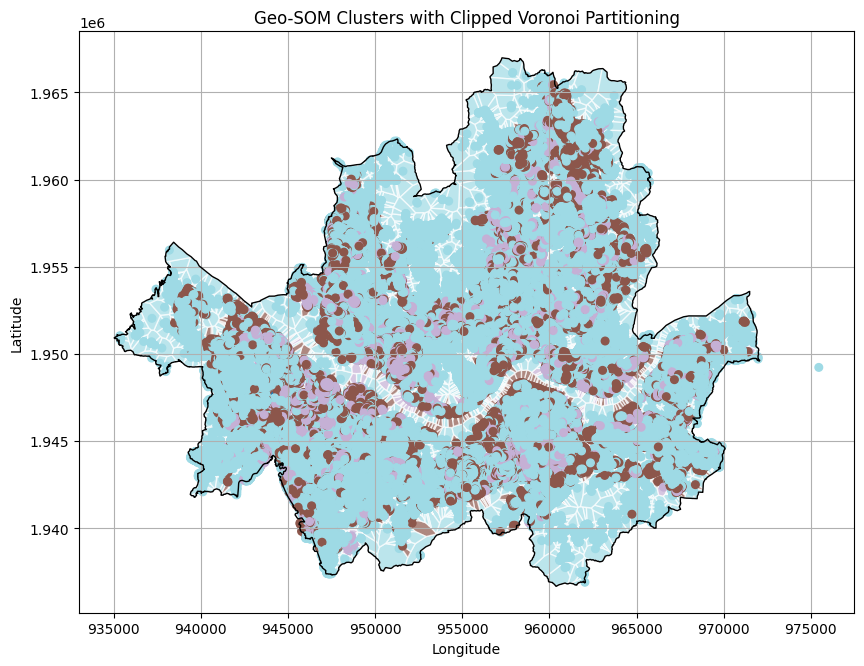

In [ ]:
# ====== 메인 실행 ======
if __name__ == "__main__":
    # 1. 포인트 준비
    X_geo = selected_gdf.geometry.apply(lambda geom: [geom.x, geom.y]).tolist()
    X_geo = np.array(X_geo)
    X_ngf = selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']].values

    # 2. GeoSOM 모델 학습
    model = GeoSOM(grid_shape=(20, 20), geo_tolerance=2, input_dim=X_ngf.shape[1], fixed_geo=True)
    model.train(X_geo, X_ngf, epochs=50)

    # 3. 클러스터 할당
    assignments = model.get_cluster_assignments(X_geo, X_ngf)

    # 4. Voronoi 폴리곤 생성 (유한/무한경계 모두 처리)
    polygons, vor = construct_voronoi_polygons(X_geo)

    # 5. Voronoi를 GeoDataFrame으로 변환
    gdf_voronoi = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=polygons, crs='EPSG:5179')  # 좌표계

    # 6. seoul_gdf 기준으로 Clip
    gdf_voronoi_clipped = gpd.clip(gdf_voronoi, seoul_gdf)

    # 7. 포인트도 GeoDataFrame으로 변환
    points = [Point(x, y) for x, y in X_geo]
    gdf_points = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=points)

    # 8. 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    seoul_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    gdf_voronoi_clipped.plot(column='cluster', cmap='tab20', edgecolor='white', alpha=0.7, ax=ax)
    gdf_points.plot(column='cluster', cmap='tab20', markersize=30, ax=ax)
    plt.title('Geo-SOM Clusters with Clipped Voronoi Partitioning')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

In [ ]:
# gdf_voronoi를 Shapefile로 저장

output_path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/voronoi_seoul1.shp'
gdf_voronoi_clipped.to_file(output_path, driver='ESRI Shapefile', encoding='utf-8')
print(f"Shapefile 저장 완료: {output_path}")


Shapefile 저장 완료: /content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/voronoi_seoul1.shp


Training GeoSOM: 100%|██████████| 50/50 [10:43:03<00:00, 771.66s/it]


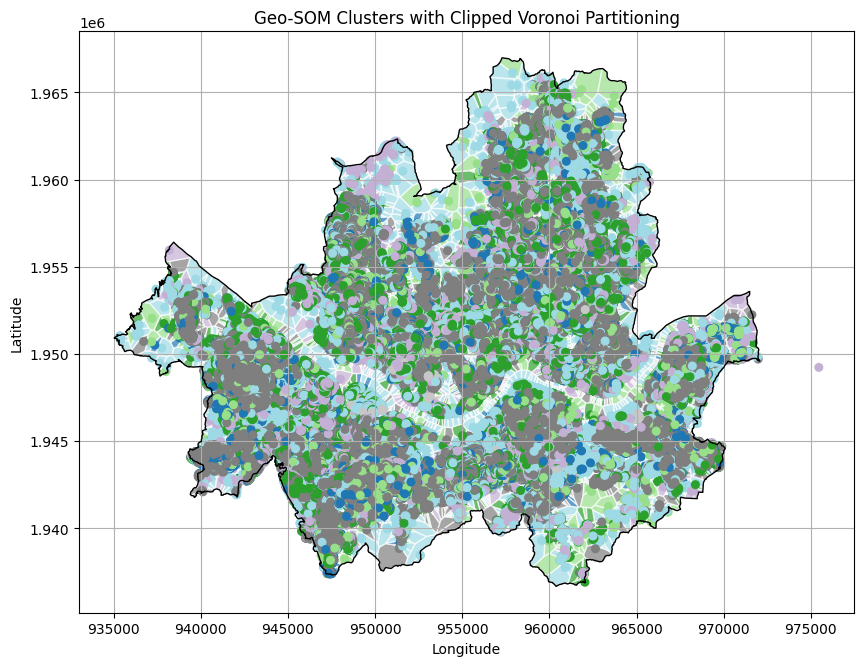

In [ ]:
# ====== 메인 실행 ======
if __name__ == "__main__":
    # 1. 포인트 준비
    X_geo = selected_gdf.geometry.apply(lambda geom: [geom.x, geom.y]).tolist()
    X_geo = np.array(X_geo)
    X_ngf = selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']].values

    # 2. GeoSOM 모델 학습
    model = GeoSOM(grid_shape=(20, 20), geo_tolerance=4, input_dim=X_ngf.shape[1], fixed_geo=True)
    model.train(X_geo, X_ngf, epochs=50)

    # 3. 클러스터 할당
    assignments = model.get_cluster_assignments(X_geo, X_ngf)

    # 4. Voronoi 폴리곤 생성 (유한/무한경계 모두 처리)
    polygons, vor = construct_voronoi_polygons(X_geo)

    # 5. Voronoi를 GeoDataFrame으로 변환
    gdf_voronoi = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=polygons, crs='EPSG:5179')  # 좌표계

    # 6. seoul_gdf 기준으로 Clip
    gdf_voronoi_clipped = gpd.clip(gdf_voronoi, seoul_gdf)

    # 7. 포인트도 GeoDataFrame으로 변환
    points = [Point(x, y) for x, y in X_geo]
    gdf_points = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=points)

    # 8. 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    seoul_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    gdf_voronoi_clipped.plot(column='cluster', cmap='tab20', edgecolor='white', alpha=0.7, ax=ax)
    gdf_points.plot(column='cluster', cmap='tab20', markersize=30, ax=ax)
    plt.title('Geo-SOM Clusters with Clipped Voronoi Partitioning')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

In [ ]:
# gdf_voronoi를 Shapefile로 저장

output_path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/voronoi_seoul2.shp'
gdf_voronoi_clipped.to_file(output_path, driver='ESRI Shapefile', encoding='utf-8')
print(f"Shapefile 저장 완료: {output_path}")


Shapefile 저장 완료: /content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/voronoi_seoul2.shp


In [ ]:
# ====== 메인 실행 ======
if __name__ == "__main__":
    # 1. 포인트 준비
    X_geo = selected_gdf.geometry.apply(lambda geom: [geom.x, geom.y]).tolist()
    X_geo = np.array(X_geo)
    X_ngf = selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']].values

    # 2. GeoSOM 모델 학습
    model = GeoSOM(grid_shape=(20, 20), geo_tolerance=6, input_dim=X_ngf.shape[1], fixed_geo=True)
    model.train(X_geo, X_ngf, epochs=50)

    # 3. 클러스터 할당
    assignments = model.get_cluster_assignments(X_geo, X_ngf)

    # 4. Voronoi 폴리곤 생성 (유한/무한경계 모두 처리)
    polygons, vor = construct_voronoi_polygons(X_geo)

    # 5. Voronoi를 GeoDataFrame으로 변환
    gdf_voronoi = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=polygons, crs='EPSG:5179')  # 좌표계

    # 6. seoul_gdf 기준으로 Clip
    gdf_voronoi_clipped = gpd.clip(gdf_voronoi, seoul_gdf)

    # 7. 포인트도 GeoDataFrame으로 변환
    points = [Point(x, y) for x, y in X_geo]
    gdf_points = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=points)

    # 8. 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    seoul_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    gdf_voronoi_clipped.plot(column='cluster', cmap='tab20', edgecolor='white', alpha=0.7, ax=ax)
    gdf_points.plot(column='cluster', cmap='tab20', markersize=30, ax=ax)
    plt.title('Geo-SOM Clusters with Clipped Voronoi Partitioning')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

Training GeoSOM: 100%|██████████| 50/50 [11:54:44<00:00, 857.69s/it]


In [ ]:
# gdf_voronoi를 Shapefile로 저장

output_path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/voronoi_seoul3.shp'
gdf_voronoi_clipped.to_file(output_path, driver='ESRI Shapefile', encoding='utf-8')
print(f"Shapefile 저장 완료: {output_path}")


NameError: name 'gdf_voronoi_clipped' is not defined

In [ ]:
# ====== 메인 실행 ======
if __name__ == "__main__":
    # 1. 포인트 준비
    X_geo = selected_gdf.geometry.apply(lambda geom: [geom.x, geom.y]).tolist()
    X_geo = np.array(X_geo)
    X_ngf = selected_gdf[['A20', 'A21', 'A30', 'total_floor', 'years_old']].values

    # 2. GeoSOM 모델 학습
    model = GeoSOM(grid_shape=(20, 20), geo_tolerance=8, input_dim=X_ngf.shape[1], fixed_geo=True)
    model.train(X_geo, X_ngf, epochs=50)

    # 3. 클러스터 할당
    assignments = model.get_cluster_assignments(X_geo, X_ngf)

    # 4. Voronoi 폴리곤 생성 (유한/무한경계 모두 처리)
    polygons, vor = construct_voronoi_polygons(X_geo)

    # 5. Voronoi를 GeoDataFrame으로 변환
    gdf_voronoi = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=polygons, crs='EPSG:5179')  # 좌표계

    # 6. seoul_gdf 기준으로 Clip
    gdf_voronoi_clipped = gpd.clip(gdf_voronoi, seoul_gdf)

    # 7. 포인트도 GeoDataFrame으로 변환
    points = [Point(x, y) for x, y in X_geo]
    gdf_points = gpd.GeoDataFrame({
        'cluster': assignments
    }, geometry=points)

    # 8. 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    seoul_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    gdf_voronoi_clipped.plot(column='cluster', cmap='tab20', edgecolor='white', alpha=0.7, ax=ax)
    gdf_points.plot(column='cluster', cmap='tab20', markersize=30, ax=ax)
    plt.title('Geo-SOM Clusters with Clipped Voronoi Partitioning')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

Training GeoSOM:  90%|█████████ | 45/50 [11:53:41<1:18:39, 943.91s/it]

In [ ]:
# gdf_voronoi를 Shapefile로 저장

output_path = '/content/drive/MyDrive/GIS_Project_GEO_SOM조/outputData/voronoi_seoul4.shp'
gdf_voronoi_clipped.to_file(output_path, driver='ESRI Shapefile', encoding='utf-8')
print(f"Shapefile 저장 완료: {output_path}")
